University of Saskatchewan <br />
Department of Geography and Planning <br />
Centre for Hydrology <br />

Process-Based Hydrological Modelling (GEOG 825) <br />
Instructor: Prof Martyn P. Clark <br />
ASSIGNMENT 01 <br />

Student: Ahmed Elkouk <br />

This notebook presents the anwsers to the exercises in assignment 01. The anwsers are examples on how 
to use the rainfall-runoff model developed in the same assignment. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flux_param import (calc_canopy_drainage_flux, 
                        calc_canopy_evaporation,
                        calc_overland_flow, 
                        calc_percolation_flux, 
                        calc_precipitation_excess, 
                        calc_saturated_fraction, 
                        calc_throughfall_flux, 
                        calc_unsaturated_evaporation, 
                        calc_wetted_fraction)
from states import (run_coupled_states, 
                    calc_canopy_state, 
                    calc_unsaturated_state)
from solver import (explicitEuler, 
                    explicitEuler_coupled_states)
from precip import synthetic_precipitation

In [2]:
# Model parameters
gamma = 2/3
canopyStore_max = 3
k_can = 0.5
fieldCap = 25.0
unsatStore_max = 100.0
alpha = 0.25
k_sat = 500.0
beta = 3.0
k_sz = 0.1

# Forcings
precip = 1.0
pet = 1.0

# 4.1 Compute the diagnostic variables used in the flux parameterizations

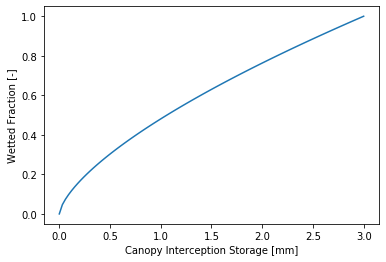

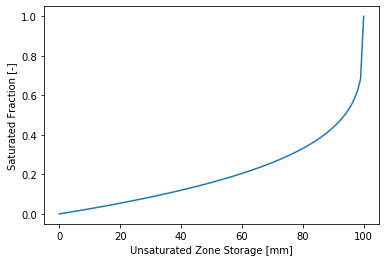

In [3]:
# Calculate Wetted Fraction
canopyStore = np.linspace(0, 3, 100)
wetFrac = np.array([calc_wetted_fraction(xi, canopyStore_max, gamma) for xi in canopyStore])

fig = plt.figure()
plt.plot(canopyStore, wetFrac)
plt.ylabel('Wetted Fraction [-]')
plt.xlabel('Canopy Interception Storage [mm]');


# Calculate Saturated Fraction
unsatStore = np.linspace(0, 100, 100)
satFrac = np.array([calc_saturated_fraction(xi, unsatStore_max, alpha) for xi in unsatStore])

fig = plt.figure()
plt.plot(unsatStore, satFrac)
plt.ylabel('Saturated Fraction [-]')
plt.xlabel('Unsaturated Zone Storage [mm]');

# 4.2 Compute the model fluxes

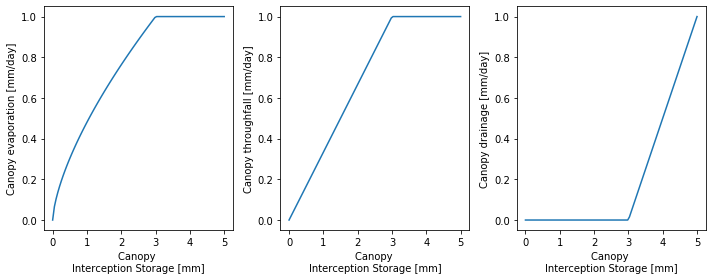

In [4]:
canopyStore = np.linspace(0, 5, 100)

# Calculate Canopy evap.
wetFrac = np.array([calc_wetted_fraction(xi, canopyStore_max, gamma) for xi in canopyStore])
intercEvap = np.array([calc_canopy_evaporation(pet, xi) for xi in wetFrac])

# Calculate Canopy throughfall
throughfall = np.array([calc_throughfall_flux(precip, xi, canopyStore_max) for xi in canopyStore])

# Calculate Canopy drainage
canopyDrain = np.array([calc_canopy_drainage_flux(xi, canopyStore_max, k_can) for xi in canopyStore])

fig, axes = plt.subplots(1, 3, figsize=(10,4))
fluxes = [intercEvap, throughfall, canopyDrain]
ylabels = ['Canopy evaporation [mm/day]', 'Canopy throughfall [mm/day]', 'Canopy drainage [mm/day]']
for i, ys in enumerate(fluxes):
    ax = axes[i]
    ax.plot(canopyStore, ys)
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Canopy \nInterception Storage [mm]');
plt.tight_layout()

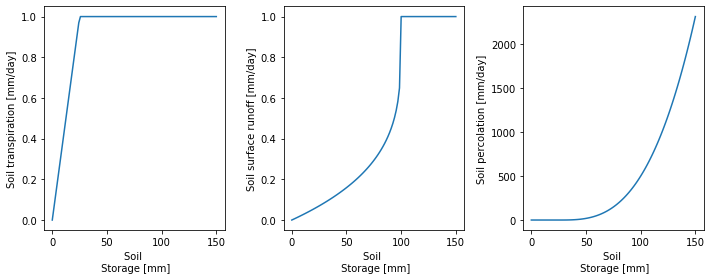

In [5]:
unsatStore = np.linspace(0, 150, 100)

# Calculate Soil transpiration
wetFrac = 0.0
unsatEvap = np.array([calc_unsaturated_evaporation(pet, xi, fieldCap, wetFrac) for xi in unsatStore])

# Calculate Soil surface runoff
satFrac = np.array([calc_saturated_fraction(xi, unsatStore_max, alpha) for xi in unsatStore])
precipExcess = precip
overlandFlow = np.array([calc_overland_flow(precipExcess, xi) for xi in satFrac])

# Calculate Soil percolation
percolation = np.array([calc_percolation_flux(xi, unsatStore_max, fieldCap, k_sat, beta) for xi in unsatStore])

fig, axes = plt.subplots(1, 3, figsize=(10,4))
fluxes = [unsatEvap, overlandFlow, percolation]
ylabels = ['Soil transpiration [mm/day]', 'Soil surface runoff [mm/day]', 'Soil percolation [mm/day]']
for i, ys in enumerate(fluxes):
    ax = axes[i]
    ax.plot(unsatStore, ys)
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Soil \n Storage [mm]');
plt.tight_layout()

# 4.3 Solve individual ODEs

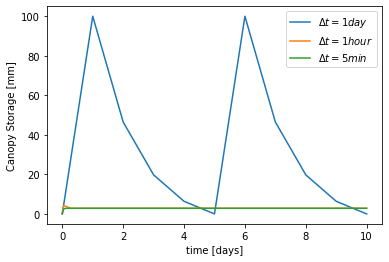

In [6]:
Sc0 = 0.0
T = 10
param = dict(precip=100.0, pet=5.0, 
             canopyStore_max=canopyStore_max, 
             gamma=gamma, k_can=k_can)

# Explicit Euler: integrate canopy state 
dts = [1, 1/24, (1/24)/60*5]  # time steps of 1-day, 1h, 5min

fig = plt.figure()
for dt in dts:
    canopyStore, t = explicitEuler(calc_canopy_state, Sc0, T, dt, **param)
    plt.plot(t, canopyStore)
plt.xlabel('time [days]')
plt.ylabel('Canopy Storage [mm]')
plt.legend(['$\Delta t=1 day$', 
            '$\Delta t=1 hour$', 
            '$\Delta t=5 min$']);

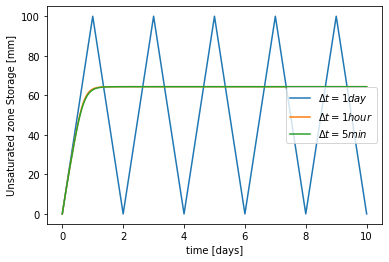

In [7]:
Suz0 = 0.0
T = 10
param = dict(precipExcess=100.0, pet=5.0, wetFrac=0.0,
             unsatStore_max=unsatStore_max, fieldCap=fieldCap, 
             alpha=alpha, beta=beta, k_sat=k_sat)

# Explicit Euler: integrate unsaturated state
dts = [1, 1/24, (1/24)/60*5]  # time steps of 1-day, 1h, 5min

fig = plt.figure()
for dt in dts:
    unsatStore, t = explicitEuler(calc_unsaturated_state, Suz0, T, dt, **param)
    plt.plot(t, unsatStore)
plt.xlabel('time [days]')
plt.ylabel('Unsaturated zone Storage [mm]')
plt.legend(['$\Delta t=1 day$', 
            '$\Delta t=1 hour$', 
            '$\Delta t=5 min$']);

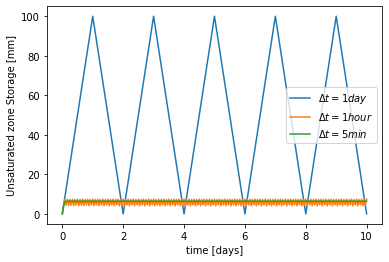

In [8]:
Suz0 = 0.0
T = 10
param = dict(precipExcess=100.0, pet=5.0, wetFrac=0.0,
             unsatStore_max=10.0, fieldCap=2.5, 
             alpha=alpha, beta=beta, k_sat=k_sat)

# Explicit Euler: integrate unsaturated statel: change parameters (Suz_max, Sfc)
dts = [1, 1/24, (1/24)/60*5]  # time steps of 1-day, 1h, 5min

fig = plt.figure()
for dt in dts:
    unsatStore, t = explicitEuler(calc_unsaturated_state, Suz0, T, dt, **param)
    plt.plot(t, unsatStore)
plt.xlabel('time [days]')
plt.ylabel('Unsaturated zone Storage [mm]')
plt.legend(['$\Delta t=1 day$', 
            '$\Delta t=1 hour$', 
            '$\Delta t=5 min$']);

# 4.4 Solve the coupled ODE system

Text(0, 0.5, 'Precipitation [mm/day]')

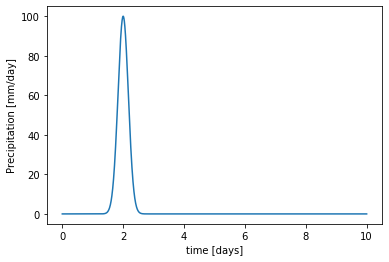

In [9]:
# Synthetic precipitation forcing
dt = (1/24)/60*5    # time step  dt=5min
t = np.arange(0, 10+dt, dt)
precip_synth = synthetic_precipitation(t)

fig = plt.figure()
plt.plot(t, precip_synth)
plt.xlabel('time [days]')
plt.ylabel('Precipitation [mm/day]')

In [10]:
# Run coupled model

# Initial conditions
initial_conditions = [0.0, 10.0, 1.0] # [canopy, unsat, sat] in [mm]
T = 10            # time period [days]
dt = (1/24)/60*5  # time step  dt=5min
t = np.arange(0, 10, dt)
precip_synth = synthetic_precipitation(t)

# Model parameters
gamma = 2/3
canopyStore_max = 3
k_can = 0.5
fieldCap = 25.0
unsatStore_max = 100.0
alpha = 0.25
k_sat = 500.0
beta = 3.0
k_sz = 0.1
params = dict(pet=5.0, canopyStore_max=canopyStore_max, 
              unsatStore_max=unsatStore_max, fieldCap=fieldCap, 
              gamma=gamma, alpha=alpha, beta=beta, k_can=k_can, 
              k_sat=k_sat, k_sz=k_sz)

# Numerical solution
storage, totalRunoff, t = explicitEuler_coupled_states(run_coupled_states, initial_conditions, 
                                                       T, dt, precip_synth, **params)

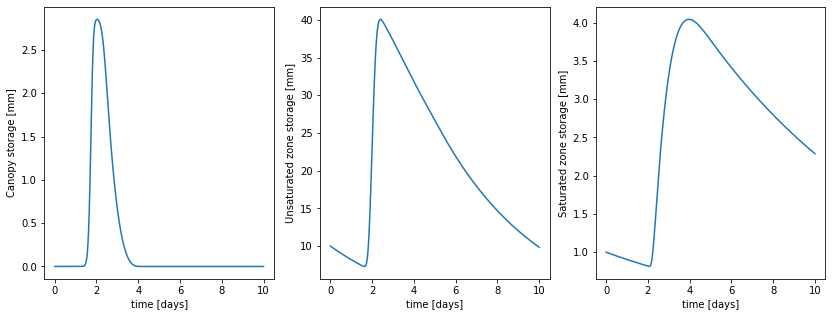

In [11]:
# States time series
fig, axes = plt.subplots(1, 3, figsize=(14,5))
ylabels = ['Canopy storage [mm]', 'Unsaturated zone storage [mm]', 'Saturated zone storage [mm]']
for i in range(3):
    ax = axes[i]
    ax.plot(t, storage[:, i])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('time [days]')

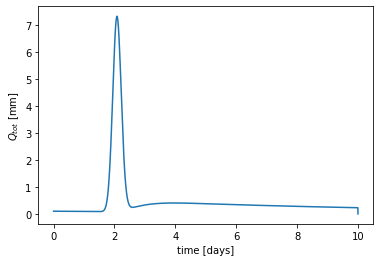

In [12]:
# Runoff time series
fig = plt.figure()
plt.plot(t, totalRunoff)
plt.xlabel('time [days]')
plt.ylabel('$Q_{tot}$ [mm]');

# 5 Additional Exercises

In [22]:
import solver as solver

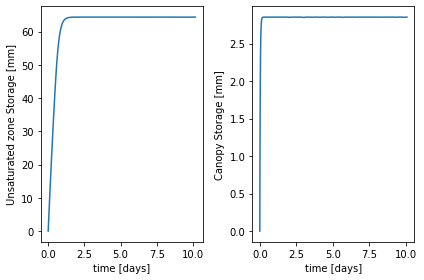

In [21]:
# Integrate states using the explicit Heun with numerical error control and adaptive substepping

# Inputs, 
dt = 1
T = 10
Si = 0.0
tau_r = 0.0001
tau_abs = 0.001
param_unsat = dict(precipExcess=100.0, pet=5.0, wetFrac=0.0,
             unsatStore_max=unsatStore_max, fieldCap=fieldCap, 
             alpha=alpha, beta=beta, k_sat=k_sat)
param_canopy = dict(precip=100.0, pet=5.0, 
             canopyStore_max=canopyStore_max, 
             gamma=gamma, k_can=k_can)

# Unsaturated zone
dS_unsat, time_unsat = solver.Heun_adaptive_substep(calc_unsaturated_state, Si, dt, T, tau_r, tau_abs, **param_unsat)

# Canopy
dS_canopy, time_canopy = solver.Heun_adaptive_substep(calc_canopy_state, Si, dt, T, tau_r, tau_abs, **param_canopy)

# Plot
fig, axes = plt.subplots(1, 2)
ylabels = ['Unsaturated zone Storage [mm]', 'Canopy Storage [mm]']
states = [dS_unsat, dS_canopy]
time = [time_unsat, time_canopy]
for i in range(2):
    ax = axes[i]
    ax.plot(np.array(time[i]).cumsum(), states[i]) # time is a list of time steps dt, 
                                                   # we use np.cumsum to cumulative time
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('time [days]')
plt.tight_layout()